## **Análisis del Sistema de Transporte Colectivo Metro de la Ciudad de México antes y durante la pandemia de COVID-19**

### **Hipótesis y fuentes**

La pandemia paralizó las ciudades durante varios meses, dejando muchos servicios suspendidos, y México no fue la excepción, reduciendo significativamente el tránsito de personas en la calle y, por ende, en el transporte público. De esta manera, cabe preguntarse:

- ¿Qué desempeño tuvo el sistema Metro de la Ciudad de México y cómo se vio afectado durante y después de la pandemia del COVID-19? 

- ¿Algún otro factor se vio implicado en el desempeño del Metro? 

Para realizar esta tarea, es necesario recolectar datos tanto de la afluencia en el Metro, como los casos confirmados de COVID-19. Las fuentes utilizadas para el análisis fueron las siguientes:

Portal del gobierno de la Ciudad de México(Afluencia del Metro): https://datos.cdmx.gob.mx/dataset/afluencia-diaria-del-metro-cdmx

Conahcyt (Informe de COVID-19 en periodo 2020-2023):  https://datos.covid-19.conacyt.mx/#DownZCSV


### **Comienzo de análisis**

Para comenzar a responder las preguntas planteadas, es necesario preparar las herramientas. En esta ocasión se usará Python y sus diversas herramientas para poder limpiar, transformar y graficar los datos. 

In [63]:
#Python 3.10.2
import pandas as pd                         
import matplotlib.pyplot as plt              
import seaborn as sns                        
from sklearn.impute import SimpleImputer



#Variables de estilos para las gráficas
d={'Línea 1': 'magenta', 'Línea 2': 'blue', 'Línea 3': 'olive', 'Línea 4': 'c', 'Línea 5': 'yellow', 
   'Línea 6': 'orange', 'Línea 7': 'green', 'Línea 8': 'red', 'Línea 9': 'brown', 'Línea A': 'darkviolet', 
   'Línea B': 'gray', 'Línea 12': 'gold'}

#Orden para graficar las líneas del Metro
order=['Línea 1','Línea 2','Línea 3','Línea 4', 'Línea 5', 'Línea 6',
       'Línea 7', 'Línea 8','Línea 9', 'Línea A', 'Línea B','Línea 12']

#Estilos de gráficas
font = {'color':  'black', 'weight': 'normal', 'size': 18}

borde_color = 'black'  # Puedes cambiar el color según tus preferencias
borde_grosor = 0.5

### **Datos del Metro en el periodo 2013-2023**

Los datos obtenidos del Metro abarcan un periodo más largo, pero para responder las preguntas podemos limitarnos a los últimos 10 años de servicio. 

In [27]:
#Acceder al csv y transformar a DataFrame
file='../dataset/afluenciastc_simple_12_2023.csv'
data_stcm=pd.read_csv(file)

#Filtrado de DataFrame
data_2013_2023 = data_stcm[(data_stcm['fecha'] >= '2013-01-01') & (data_stcm['fecha'] <= '2023-12-31')]
data_2013_2023.to_csv('../dataset/afluencia_2013-2023.csv', index=False)

### **Datos de COVID-19 en CDMX del periodo 2020-2023**

<div style="text-align: justify">
En el siguiente código solamente se muestra la limpieza de los datos, excluyendo los valores fuera de la CDMX. Para el análisis transformó de formato ancho a formato largo para poder tener los datos de manera adecuada. La herramienta para hacerlo fue Excel para facilidad, pero en el repositorio se encuentra el dataset antes y después de la transformación. </div>

In [ ]:
#Acceder al csv y transformar a DataFrame
file='../dataset/Casos_Diarios_Estado_Nacional_Confirmados_20230625.csv'
data_covid=pd.read_csv(file)


#Filtrado de DataFrame
data_2020_2023 = data_covid[(data_covid['nombre'] == 'DISTRITO FEDERAL')]
data_2020_2023.to_csv('../dataset/covid_cdmx_2020-2023.csv', index=False)

### **Desempeño del Metro**

<div style="text-align: justify">
El primer caso que hay que analizar es el desempeño total del Metro en los últimos años, esto para poder tener una buena referencia histórica.  El primer paso para esto es agrupar según su afluencia a lo largo de los 10 años de estudio. Por simplicidad, solamente se tomarán los años y la afluencia total de estas. A continuación, se ve la transformación de los datos. 
</div>


In [28]:
# Preparando formato de año y afluencia
data_1={'anio':[],'afluencia':[] }
data_year = pd.DataFrame(data_1)

#Filtrado de dataframe según un rango establecido y con un formato cómodo para su posterior uso
for i in range(2013,2024):
    data_temp = data_2013_2023[data_2013_2023['anio'] == i]
    sum_afluencia = data_temp['afluencia'].sum()
    new_row = {'anio': [str(i)], 'afluencia': [sum_afluencia]}
    df1=pd.DataFrame(new_row)
    data_year = pd.concat([data_year,df1], ignore_index=True)

#Casteo de columnas para su correcta maniplación
data_year['afluencia'] = data_year['afluencia'].astype(int)
data_year['anio'] = data_year['anio'].astype(int)
data_year['afluencia'] = data_year['afluencia'].map('{:,}'.format)

#print(data_year)

### **Casos confirmados de COVID-19**

<div style="text-align: justify">
La otra variable del análisis son los casos de COVID, por lo que de igual manera se agruparán los datos de manera anual, para poderlos comparar con la afluencia anual del Metro.
</div>


In [29]:
#Obtener DataFrame y transformar la columna fecha para su posterior uso
file='../dataset/covid_cdmx_2020-2023.csv'
data_covid=pd.read_csv(file, parse_dates=['fecha'], dayfirst=True)
data_covid['anio'] = pd.DatetimeIndex(data_covid['fecha']).year

#Agryupamiento de casos por año
data_covid=data_covid.groupby(['anio'])['casos'].sum().reset_index()

#Casteo de datos 
data_covid['casos'] = data_covid['casos'].astype(int)
data_covid['anio'] = data_covid['anio'].astype(int)
data_covid['casos'] = data_covid['casos'].map('{:,}'.format)

#data_covid.head()

### **Juntar dataframes** 

<div style="text-align: justify">
Aquí se juntan ambos dataframes para que sea fácilmente comparado y graficado. La idea de hacer esto es simplificar un poco la creación de la gráfica comparativa, por lo que el DataFrame resultante no será manipulado posteriormente. 
</div>


In [30]:
#Juntar ambos Dataframes (similar a JOIN)
data_comparative = pd.merge(data_year, data_covid, on='anio', how='left')

#Pasamos a un formato largo para graficar
df_long = pd.melt(data_comparative, id_vars=['anio'], value_vars=['afluencia', 'casos'],
                  var_name='Variable', value_name='Valor')

#Casteo para operaciones
df_long['Valor'] = df_long['Valor'].str.replace(',', '')
df_long['Valor'] = df_long['Valor'].fillna(0).astype(int)

#print(df_long)

### **Gráfica comparativa**

<div style="text-align: justify">
La siguiente gráfica muestra la relación entre ambos datasets. Al observarlos detenidamente podemos ver que existe una causalidad, lo que podría reflejar que el aumento de casos de COVID-19 redujo drásticamente el uso del Sistema Metro, lo cual hace sentido según las medidas de contención implementadas a lo largo del mundo, afectando de igual manera a este sistema de transporte. Un dato interesante que nos puede decir esta primera gráfica, es que el año 2021 fue el más afectado, ya que se redujo a la mitad el número de usuarios activos en el Metro, coincidiendo en el aumento de casos positivos dados por los registros.
</div>


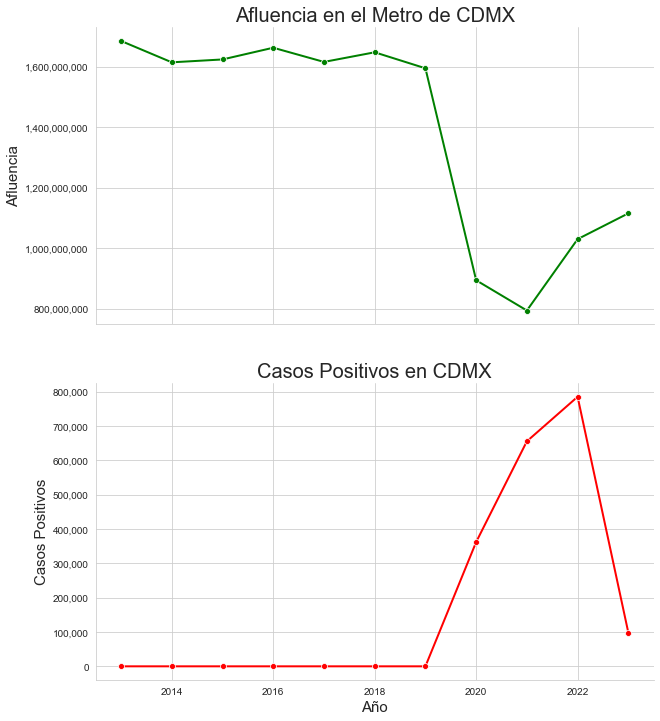

In [31]:
#Configuración de la figura 
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)


#Sección del Metro

sns.lineplot(ax=axes[0], data=df_long[df_long['Variable'] == 'afluencia'], x='anio', y='Valor', marker='o', linestyle='-', linewidth=2, color='g')
axes[0].set_title("Afluencia en el Metro de CDMX", fontsize=20)
axes[0].set_xlabel("Año", fontsize=15)
axes[0].set_ylabel("Afluencia", fontsize=15)

#Sección del COVID

sns.lineplot(ax=axes[1], data=df_long[df_long['Variable'] == 'casos'], x='anio', y='Valor', marker='o', linestyle='-', linewidth=2, color='r')
axes[1].set_title("Casos Positivos en CDMX", fontsize=20)
axes[1].set_xlabel("Año", fontsize=15)
axes[1].set_ylabel("Casos Positivos", fontsize=15)


for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

sns.despine()
plt.show()

### **Análisis de líneas individuales**

<div style="text-align: justify">
Para poder confirmar lo dicho anteriormente, es necesario analizar cada una de las líneas y comprobar si no existen elementos que hayan afectado o sesgado los datos. A continuación, se muestran los datos individuales para observar el comportamiento dentro del periodo en el que se ve la disminución de usuarios y que coincide con el aumento de casos de COVID-19 confirmados.
</div>


In [32]:
pd.options.mode.chained_assignment = None

#Cateamos las fechas para su uso adecuado
data_2013_2023['fecha'] = pd.to_datetime(data_2013_2023['fecha'])

#Agrupamos la afluencia de toda la línea por día
result_by_line = data_2013_2023.groupby(['fecha', 'linea', 'anio'])['afluencia'].sum().reset_index()

#filtrado de datos para obtener periodo 2020-2023
result_by_line=result_by_line.loc[(result_by_line['fecha'] >= '2020-01-01')
                     & (result_by_line['fecha'] < '2023-12-31')]


pd.options.mode.chained_assignment = 'warn'

### **Gráficas por línea**

<div style="text-align: justify">
Con los datos separados y graficados, podemos ver que el comportamiento es bastante similar en cada una de las líneas del Metro, pero con marcadas excepciones, siendo que hay periodos en los cuales la afluencia baja drásticamente a 0, lo que puede indicar que ocurrió algo que afectó negativamente el servicio, suspendiendo su funcionamiento. 
</div>


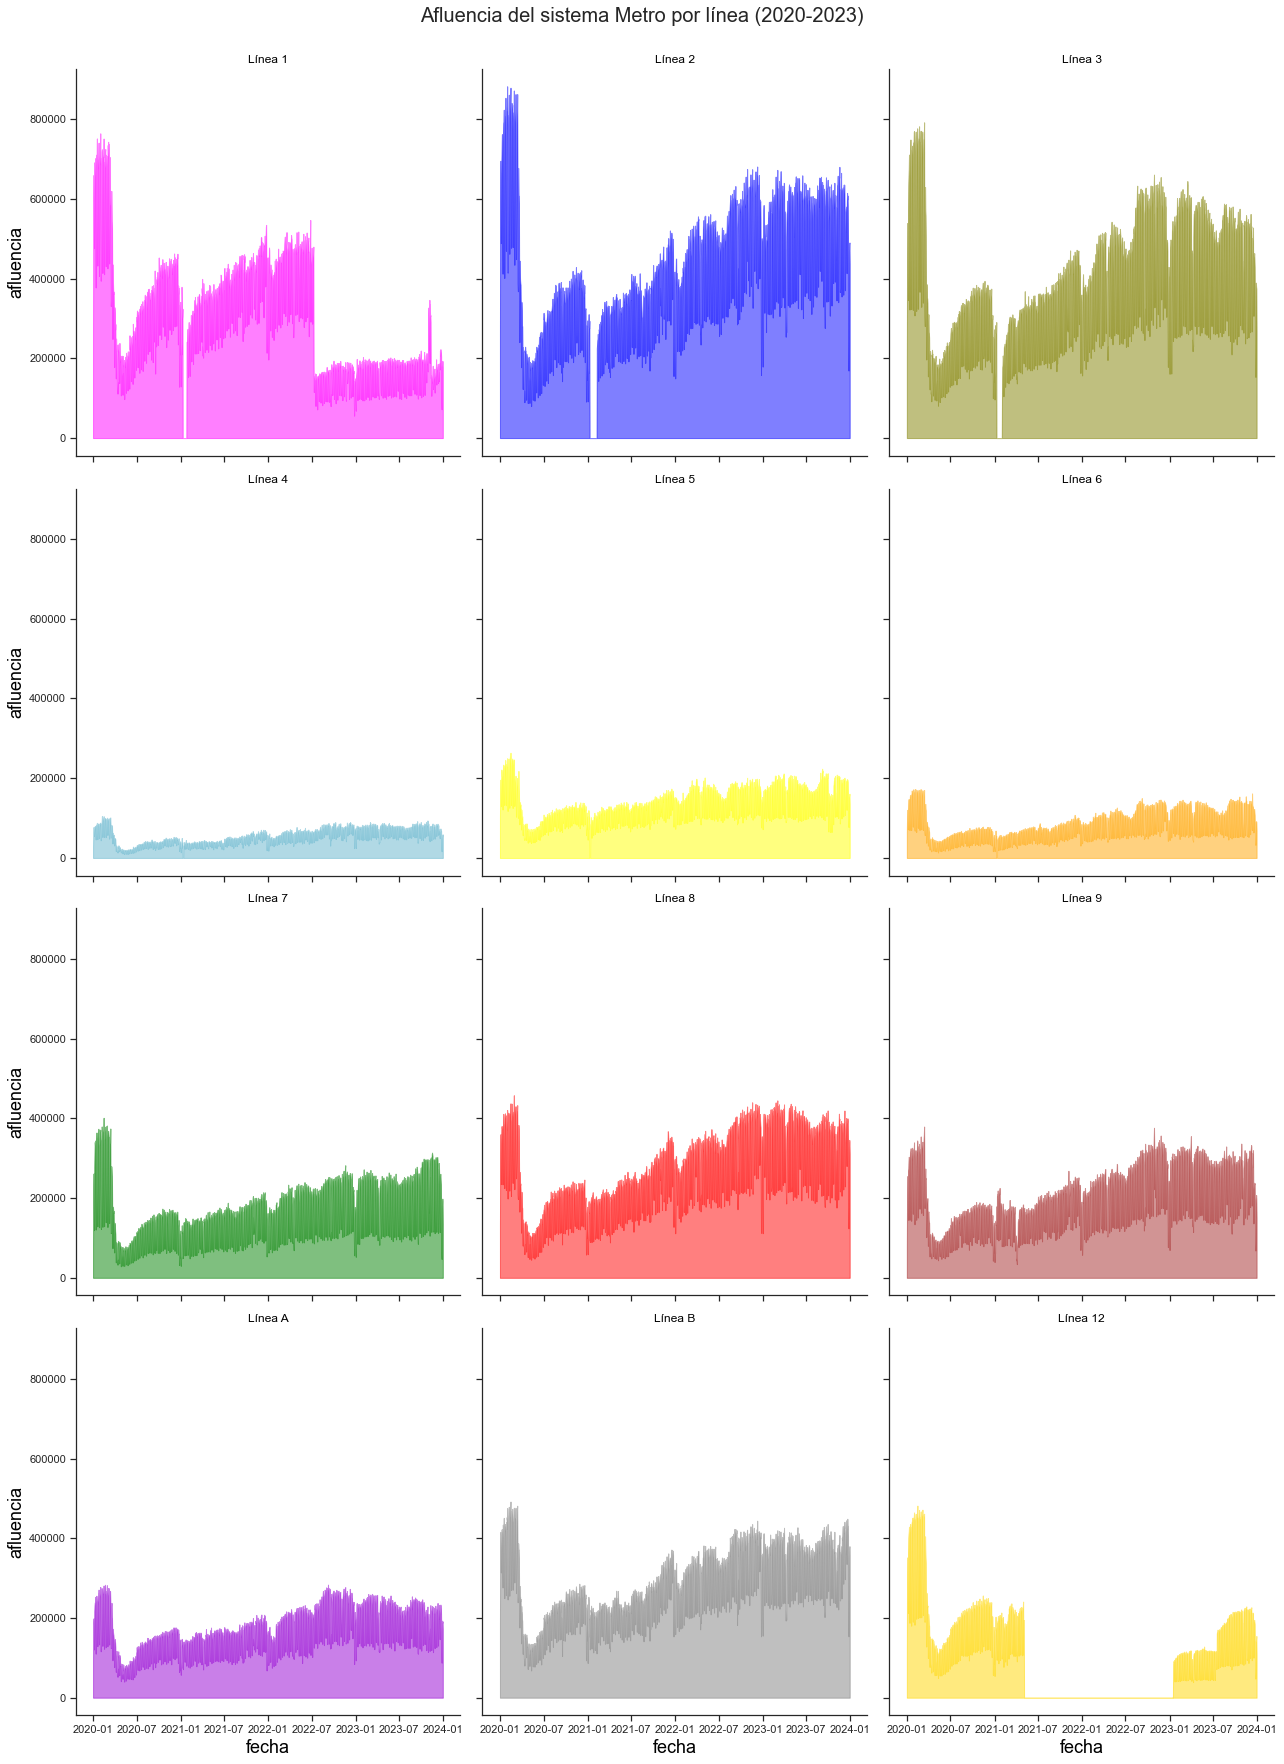

In [54]:
#Quitamos el indice para que se pueda graficar correctamente
result_by_line = result_by_line.reset_index(drop=True)

#Gráfica con grid para cada una de las líneas
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

g = sns.FacetGrid(result_by_line, col='linea', col_wrap=3, height=6, hue='linea', palette=d, col_order=order)
g.map(plt.fill_between, 'fecha', 'afluencia', alpha=0.5)

#Estilos del texto
g.set_titles(fontdict=font, template='{col_name}',loc='center')
g.set_xlabels(fontdict=font)
g.set_ylabels(fontdict=font)
g.tight_layout()
g.figure.suptitle('Afluencia del sistema Metro por línea (2020-2023)', fontsize=20, y=1.02)

plt.show()


### **¿Qué ocurrió en 2021 en el Metro?**

<div style="text-align: justify">
Podemos observar que en el año 2021 se dieron casos en los que el Metro no registró usuarios en algunas de las líneas, por lo que debemos tomarlas en cuenta para saber si estas influyeron significativamente al resultado general, por lo que ahora cabe mencionar los tres sucesos ocurridos y cuáles fueron sus consecuencias.
</div>

- #### Incendio PCCI en la Ciudad de México
    <div style="text-align: justify">
    El 9 de enero ocurrió una tragedia en el Puesto Central de Control I, donde un incendio consumió las instalaciones de control, afectando a diversas líneas del sistema Metro, siendo más específicos, las más afectadas fueron las líneas 1,2,3,4,5 y 6. Estas permanecieron cerradas por varios días, reanudando labores en fechas diferentes, siendo la línea 2 la última en abrir el 8 de febrero del 2021, casi un mes después del incidente.  

    Si deseas saber un poco más, puedes consultar la noticia en la siguiente nota de [Excelsior](https://www.excelsior.com.mx/comunidad/asi-se-vivio-incendio-en-cerebro-del-metro-6-lineas-suspendidas/1426145) o en tu medio de información de preferencia. 
    </div>
<br>

- #### Falla de la línea 12 del Metro
    <div style="text-align: justify">
    El 3 de mayo del 2021 un accidente ocurrió en el tramo elevado de la línea 12 del Metro debido a una falla estructural, este accidente provocó que la línea 12 dejara de dar servicio por más de dos años, afectando significativamente a los usuarios. La apertura total de la línea se realizó hasta el 30 de enero de 2023. 

    De igual manera, si deseas saber más de este hecho, puedes consultar la noticia en la siguiente nota de [Corazón de la Capital](https://www.capital21.cdmx.gob.mx/noticias/?p=22959#:~:text=El%20desplome%20en%20la%20L%C3%ADnea,Preliminar%20Fase%201%20de%20las) o puedes consultar tu medio de información de preferencia.
    </div>

<br>

- #### Mantenimiento y renovación de la línea 1 del Metro
    <div style="text-align: justify">
    La línea 1 del Metro cerró parcialmente en julio del 2022 debido al mantenimiento y renovación de sus instalaciones. Este suceso afectó el tramo Pantitlán-Salto del Agua, finalizando el primer tramo el 29 de octubre de 2023, mientras que el 9 de noviembre a la fecha actual del informe, se mantendrá cerrado el segundo tramo de la línea para realizar labores de mantenimiento y renovación.   
    
    Si deseas investigar más o leer detalladamente este evento, puedes consultar la tota de [El País](https://elpais.com/mexico/2023-11-09/linea-1-del-metro-que-estaciones-estan-abiertas-y-cuales-cierran-por-las-nuevas-reparaciones.html) o consultar tu medio de información de preferencia.
    </div>



### **¿Qué podemos concluir?**

<div style="text-align: justify">
El periodo de 2020 a 2023 no fue el más adecuado para el Metro, ya que se vio afectado por accidentes que imposibilitaron su funcionamiento, lo que resultó en una caída de usuarios en sus estaciones. A pesar de esto, aún podemos usar algunas técnicas para poder ver qué tanto se vio afectado el Metro por el COVID-19 independientemente de las tragedias sucedidas. </div>
<br>
<div style="text-align: justify">
El mantenimiento de la línea 1 no será considerado para el posterior análisis, esto ya que fue algo planeado por la administración del sistema Metro, pero aun así es importante considerar que este suceso igualmente afectó el desempeño del Metro.</div>
<br>
<div style="text-align: justify">
Para darnos una idea de qué efectos tuvieron los accidentes, se usará una técnica llamada ***imputación***, la cual nos permitirá reemplazar los valores 0 al promedio de valores obtenidos. La imputación se realizará con los valores dentro del periodo 2020-2023 que es el rango en el que existen valores similares, lo que evitará que creen picos en los valores. </div>



In [66]:
pd.options.mode.chained_assignment = None

#Agrupamiento de valores por fecha en cada una de las líneas
result_by_line = data_2013_2023.groupby(['fecha', 'linea','anio'])['afluencia'].sum().reset_index()
result_by_line = result_by_line.sort_values(by=['linea','fecha'])

#Creamos DataFrame y prepararemos para imputar los valores
hypotesis_dataframe=result_by_line.copy(deep=True)
#Los ceros los psaremos a NaN para imputar más facilmente y nos aseguramos de que esté, em formato numérico
hypotesis_dataframe['afluencia'] = hypotesis_dataframe['afluencia'].replace(0, pd.NA)
hypotesis_dataframe['afluencia'] = pd.to_numeric(hypotesis_dataframe['afluencia'], errors='coerce')
imputer = SimpleImputer(strategy='mean')

#Para cada una de las lineas, se sacarán los promedios para imputar los valores faltantes.
for linea in hypotesis_dataframe['linea'].unique():
    #Filtro por línea y en el periodo establecido 
    linea_df = hypotesis_dataframe.loc[(hypotesis_dataframe['linea'] == linea)
                                    & (hypotesis_dataframe['fecha'] >= '2020-01-01')
                                    & (hypotesis_dataframe['fecha'] < '2023-12-31')]
    #Se aplica la imputación y se actualizan los valores en el DataFrame original
    linea_df['afluencia'] = imputer.fit_transform(linea_df[['afluencia']])
    hypotesis_dataframe.loc[hypotesis_dataframe['linea'] == linea] = linea_df


#Copias para graficar posteriormente
real=result_by_line.copy(deep=True)
hypotesis=hypotesis_dataframe.copy(deep=True)

#agrupamos por año y contamos la afluencia en estos
hypotesis_dataframe = hypotesis_dataframe.groupby(['anio'])['afluencia'].sum().reset_index()
result_by_line = result_by_line.groupby(['anio'])['afluencia'].sum().reset_index()

#Nos aseguramos de que sean de tipo entero
result_by_line['afluencia'] = result_by_line['afluencia'].astype(int)
hypotesis_dataframe['afluencia'] = hypotesis_dataframe['afluencia'].astype(int)

#Usamos el campo año como indice para la gráfica
hypotesis_dataframe.set_index('anio',  inplace=True)
result_by_line.set_index('anio',  inplace=True)

pd.options.mode.chained_assignment = 'warn'

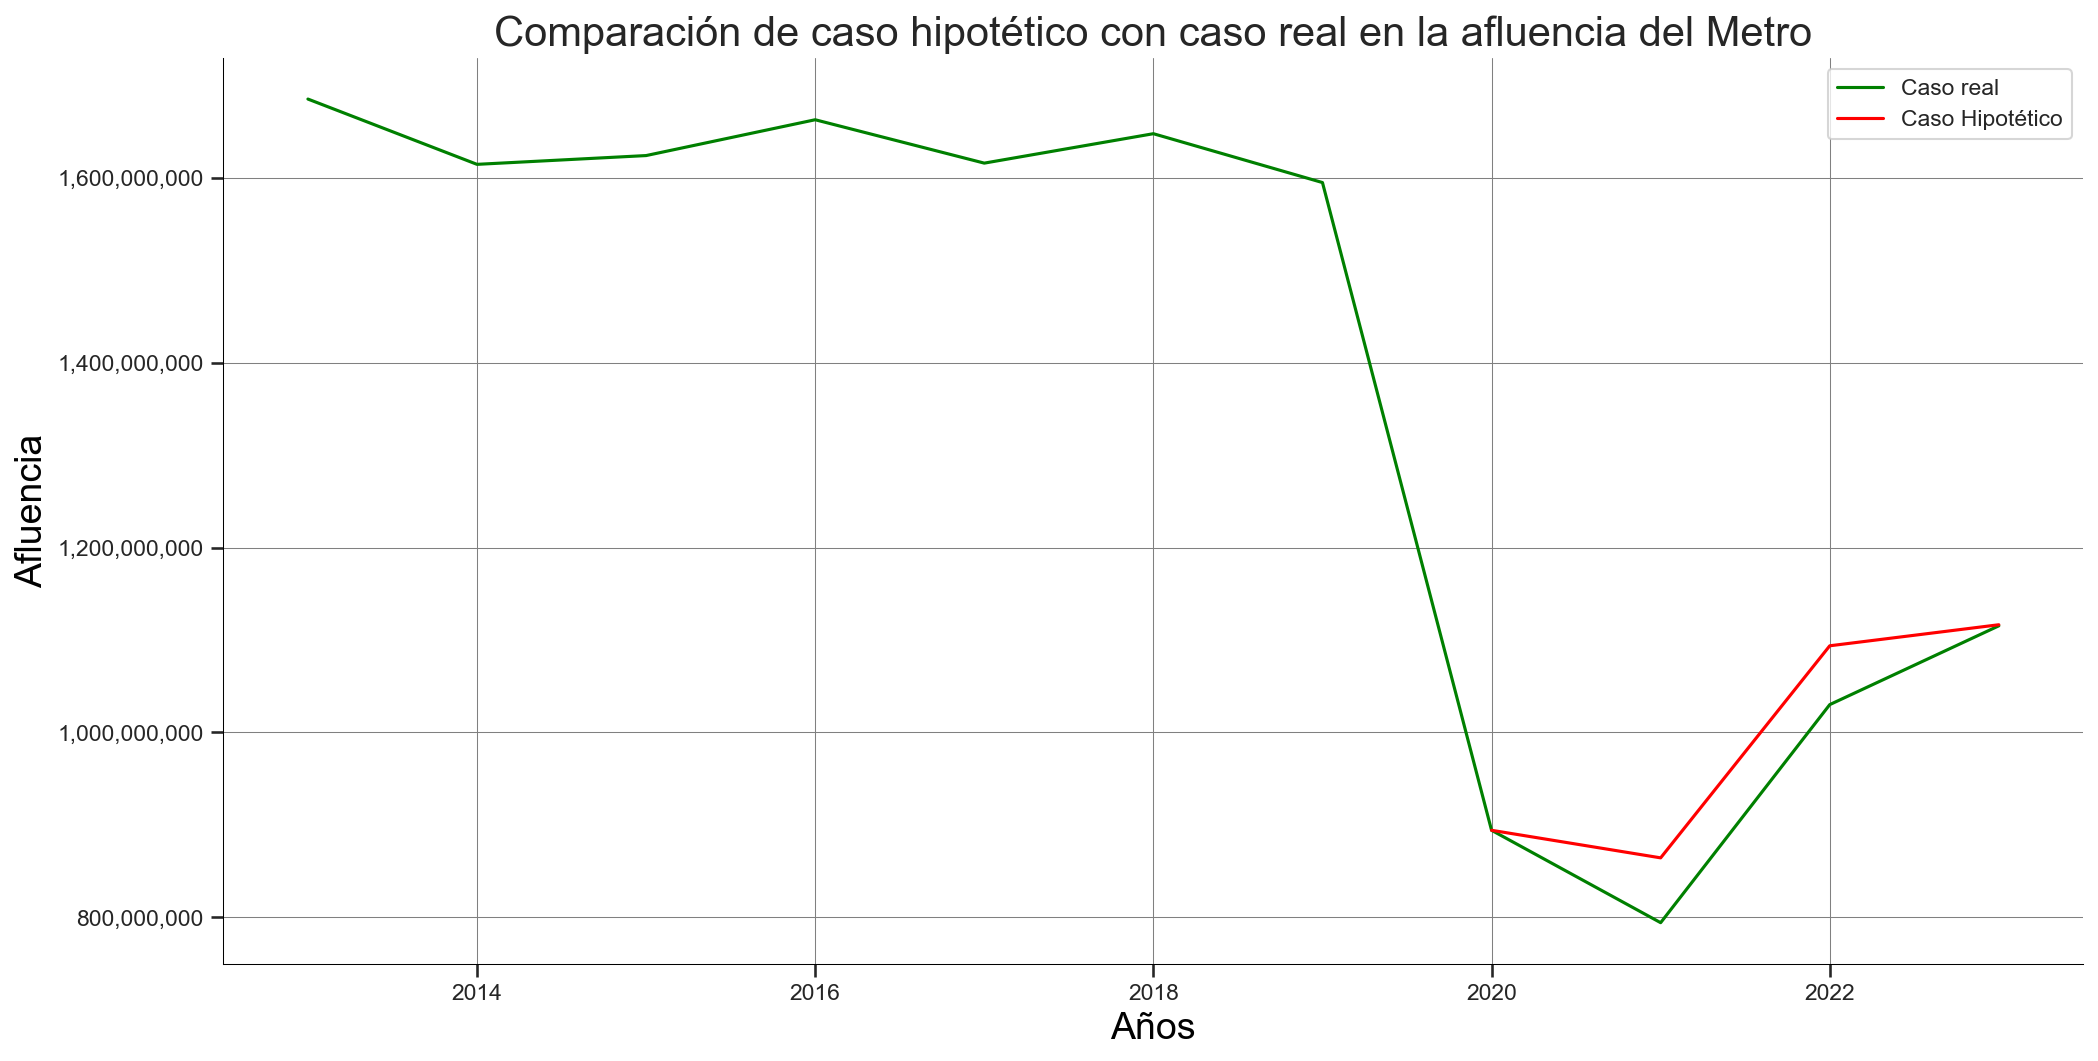

In [67]:
#Graficamos
plt.figure(figsize=(16, 8), dpi=150,edgecolor='black')


result_by_line['afluencia'].plot(label='Caso real', color='green')
hypotesis_dataframe['afluencia'].plot(label='Caso Hipotético', color='red')
plt.title('Comparación de caso hipotético con caso real en la afluencia del Metro', fontsize=20, y=1)
plt.xlabel('Años', fontdict=font) 
plt.ylabel('Afluencia', fontdict=font)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.grid(color='gray', linestyle='-', linewidth=0.5)

plt.gca().spines['left'].set_color(borde_color)
plt.gca().spines['left'].set_linewidth(borde_grosor)

plt.gca().spines['bottom'].set_color(borde_color)
plt.gca().spines['bottom'].set_linewidth(borde_grosor)

plt.gca().spines['right'].set_color(borde_color)
plt.gca().spines['right'].set_linewidth(borde_grosor)

plt.gca().spines['top'].set_color(borde_color)
plt.gca().spines['top'].set_linewidth(borde_grosor)

plt.legend() 
plt.show()

### **Resultados preliminares**

<div style="text-align: justify">
Como se vio en la gráfica anterior, nuestro pequeño caso hipotético determinó que los incidentes ocurridos en el periodo 2020-2023 sí afectaron el uso del Metro, sin embargo, podemos ver que no difiere mucho del resultado real que se había analizado anteriormente, por lo que ahora toca ver un poco el comportamiento individual de cada una de las líneas y ver qué tanto difieren del resultado real. </div>
<br>
<div style="text-align: justify">
En el siguiente gráfico se puede ver que, si bien los intervalos que estaban vacíos ya no se encuentran, estos no difieren demasiado de los que se obtuvieron anteriormente, siendo la línea 12 la única que tiene un gran cambio y siendo esta la que hizo que la afluencia general disminuyera en el 2021 y en el 2022. </div>


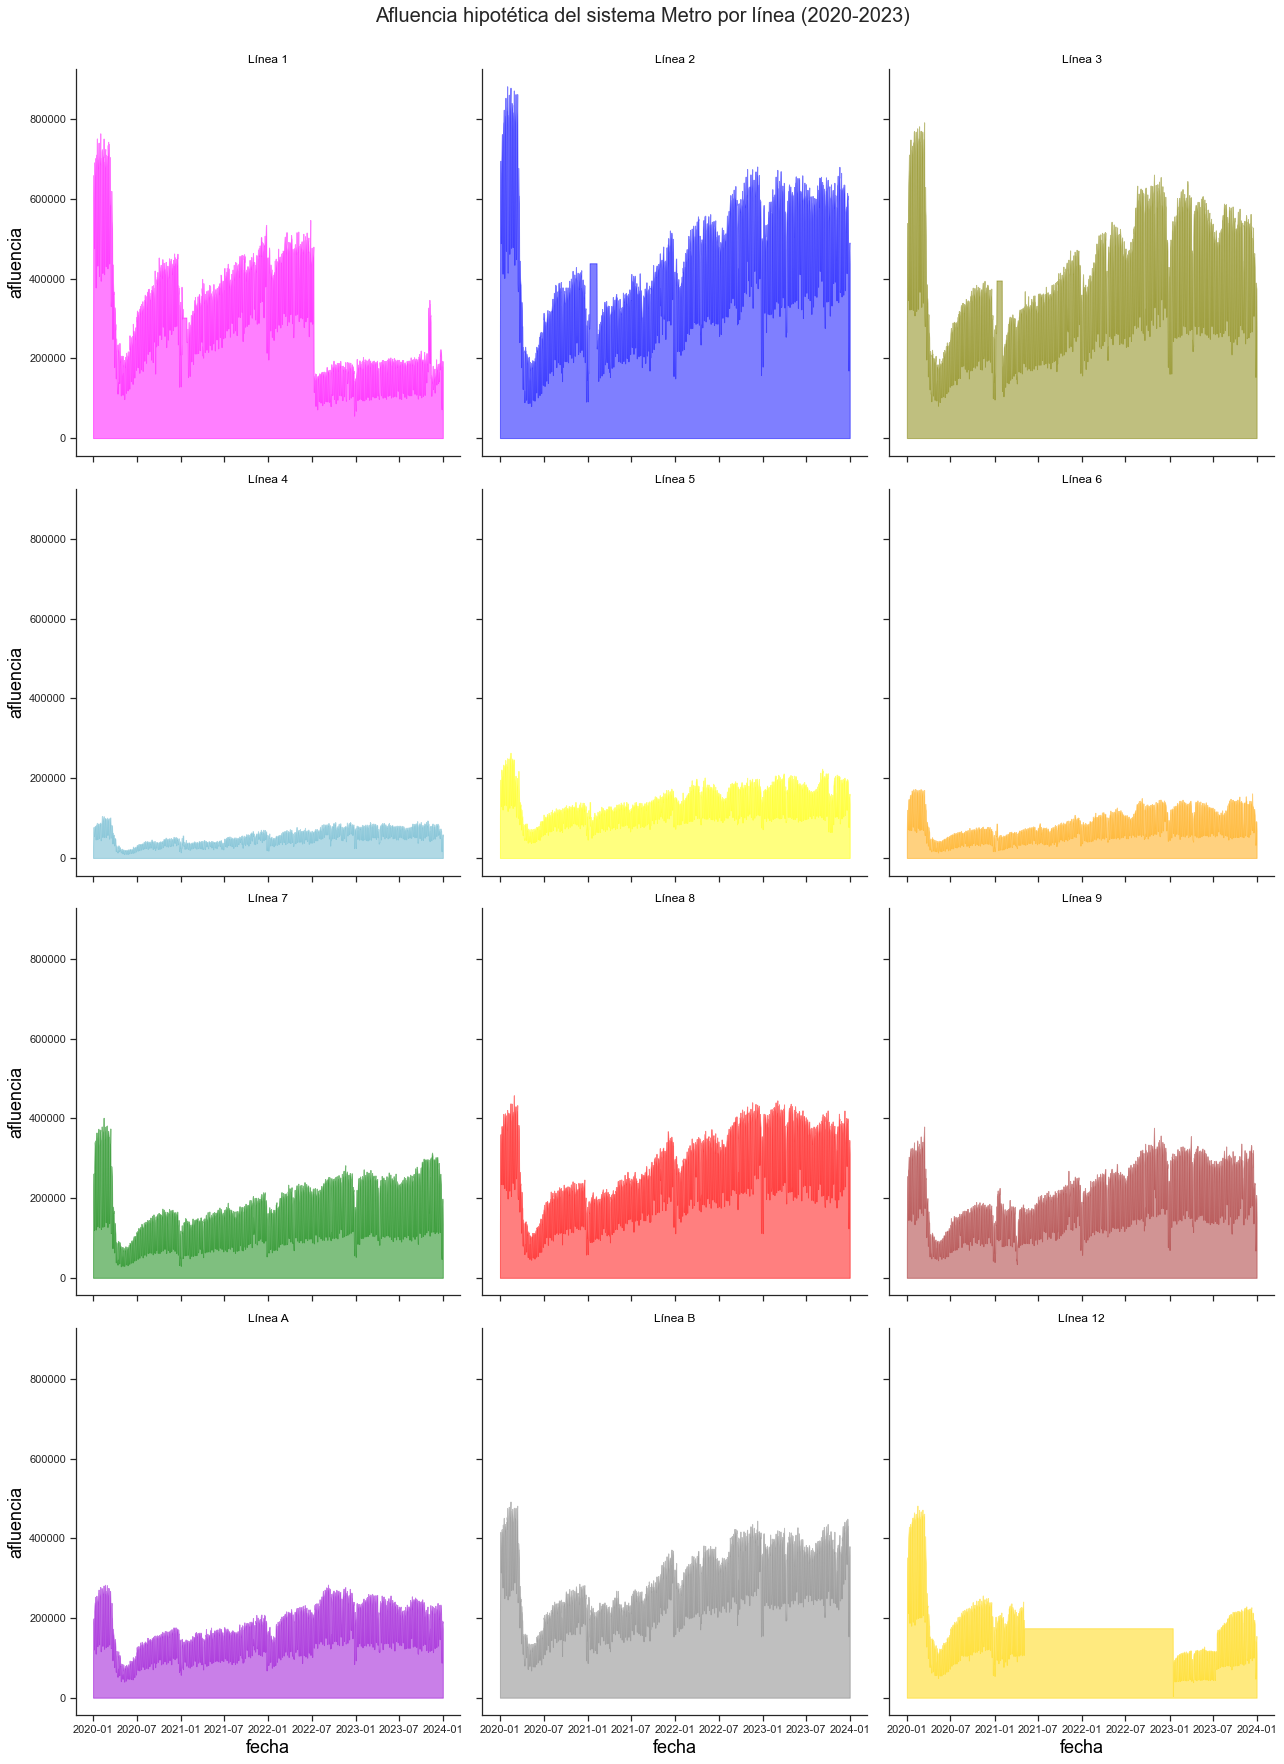

In [65]:
#Creación de gráficas para cada una de las líneas en el caso hipotético
g = sns.FacetGrid(hypotesis, col='linea', col_wrap=3, height=6, hue='linea', palette=d, col_order=order)
g.map(plt.fill_between, 'fecha', 'afluencia', alpha=0.5)

#Estilos del texto
g.set_titles(fontdict=font, template='{col_name}',loc='center')
g.set_xlabels(fontdict=font)
g.set_ylabels(fontdict=font)
g.tight_layout()
g.figure.suptitle('Afluencia hipotética del sistema Metro por línea (2020-2023)', fontsize=20, y=1.02)

plt.show()